In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function

def sigmoid_interpolation(start, end, steps):
    """
    Interpolates between start and end values using a sigmoid function over a specified number of steps.
    """
    x = np.linspace(-6, 6, steps)  # Range chosen to cover the significant transition of the sigmoid curve
    y = expit(x)  # Sigmoid function
    interpolated_values = start + (end - start) * y
    return interpolated_values

In [16]:
filepath = "../data/muir-woods-ndvi-ee-chart.csv"
ndvi = pd.read_csv(filepath)
ndvi = ndvi.ffill()
ndvi["timestamp"] = pd.to_datetime(ndvi["system:time_start"])
#ndvi = ch01[["CH1", "timestamp"]]
ndvi.head()

,system:time_start,NDVI,fitted,timestamp
0,"Jun 28, 2022",0.709,0.696,2022-06-28
1,"Jul 5, 2022",0.709,0.697,2022-07-05
2,"Jul 5, 2022",0.709,0.697,2022-07-05
3,"Jul 14, 2022",0.689,0.697,2022-07-14
4,"Jul 21, 2022",0.687,0.696,2022-07-21


In [17]:
# Normalize each column to the range [0, 1]
ndvi["NDVI_normalized"] = (ndvi["fitted"] - ndvi["fitted"].min()) / (ndvi["fitted"].max() - ndvi["fitted"].min())
ndvi.set_index("timestamp", inplace=True)
ndvi.head()

,system:time_start,NDVI,fitted,NDVI_normalized
timestamp,,,,
2022-06-28,"Jun 28, 2022",0.709,0.696,0.924242
2022-07-05,"Jul 5, 2022",0.709,0.697,0.931818
2022-07-05,"Jul 5, 2022",0.709,0.697,0.931818
2022-07-14,"Jul 14, 2022",0.689,0.697,0.931818
2022-07-21,"Jul 21, 2022",0.687,0.696,0.924242


In [22]:
ndvi.dtypes

system:time_start     object
NDVI                 float64
fitted               float64
NDVI_normalized      float64
dtype: object

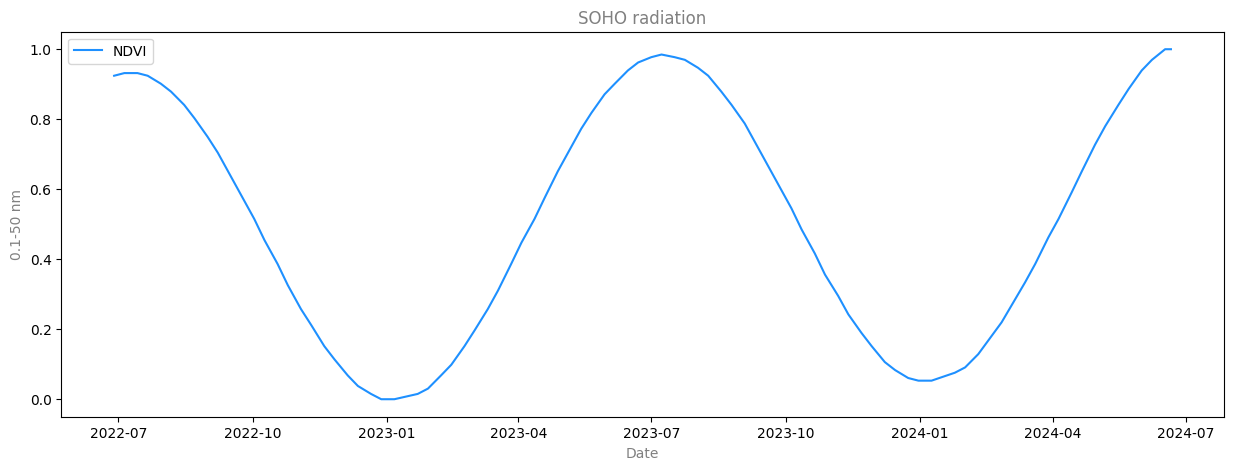

In [19]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(ndvi.index, ndvi["NDVI_normalized"], color="dodgerblue", label="NDVI")
plt.legend(loc='upper left')
plt.xlabel('Date', color='grey')
plt.ylabel('0.1-50 nm', color='grey')
plt.title('SOHO radiation', color='grey')
plt.legend(loc='upper left')
plt.savefig("../img/soho.png")
plt.show()

In [20]:
# Define the desired frequency for resampling
desired_freq = '30min'  # 30-minute intervals

# Initialize an empty DataFrame to hold interpolated data
interpolated_data = pd.DataFrame()


In [23]:
# Process each column separately
for column in ndvi.columns:
    # Drop NaN values to work with actual data points
    data = ndvi[column].dropna()

    # Convert data to numeric, handling non-numeric values as NaN
    data = pd.to_numeric(data, errors='coerce').dropna()

    # Create a new Series to hold the interpolated series
    interpolated_series = pd.Series(dtype=float)

    # Iterate over each pair of consecutive data points
    for i in range(len(data) - 1):
        start_time = data.index[i]
        end_time = data.index[i + 1]
        start_value = data.iloc[i]
        end_value = data.iloc[i + 1]

        # Ensure start_value and end_value are numeric
        if isinstance(start_value, str) or isinstance(end_value, str):
            continue  # Skip interpolation if values are non-numeric

        # Generate timestamps between start and end at the desired frequency
        timestamps = pd.date_range(start=start_time, end=end_time, freq=desired_freq)[1:-1]

        # Perform sigmoid interpolation
        interpolated_values = sigmoid_interpolation(float(start_value), float(end_value), len(timestamps))

        # Create a temporary series with interpolated values
        temp_series = pd.Series(interpolated_values, index=timestamps)

        # Concatenate the temporary series to the interpolated series
        interpolated_series = pd.concat([interpolated_series, temp_series])

    # Combine with original data
    interpolated_series = pd.concat([interpolated_series, data])

    # Sort the index to maintain chronological order
    interpolated_series = interpolated_series.sort_index()

    # Add the interpolated series to the DataFrame
    interpolated_data[column] = interpolated_series

# Resample the interpolated data to ensure consistent 30-minute intervals
interpolated_data = interpolated_data.resample(desired_freq).mean()

# Forward-fill any remaining NaN values
interpolated_data = interpolated_data.ffill()

# Define the start and end dates for trimming
start_date = pd.Timestamp("2023-06-21 15:00:00")
end_date = pd.Timestamp("2024-06-20 20:30:00")

# Ensure the end_date is included in the index
if end_date not in interpolated_data.index:
    # Add the end_date to the index with NaN values
    interpolated_data.loc[end_date] = np.nan
    # Sort the index to maintain chronological order
    interpolated_data = interpolated_data.sort_index()
    # Forward-fill the NaN value at end_date
    interpolated_data = interpolated_data.ffill()

# Trim the data to the specified date range
trimmed_data = interpolated_data.loc[start_date:end_date]

trimmed_data.tail()


/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_49715/3853737914.py:33: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_49715/3853737914.py:33: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  interpolated_series = pd.concat([interpolated_series, temp_series])
/var/folders/ww/rg8zlhq16mqg0kz1wk66r9b00000gn/T/ipykernel_49715/3853737914.py:33: FutureWarning: The behavior of array concatenation with empty entries is deprecated

,system:time_start,NDVI,fitted,NDVI_normalized
2024-06-20 18:30:00,NaN,0.718,0.706,1.0
2024-06-20 19:00:00,NaN,0.718,0.706,1.0
2024-06-20 19:30:00,NaN,0.718,0.706,1.0
2024-06-20 20:00:00,NaN,0.718,0.706,1.0
2024-06-20 20:30:00,NaN,0.718,0.706,1.0


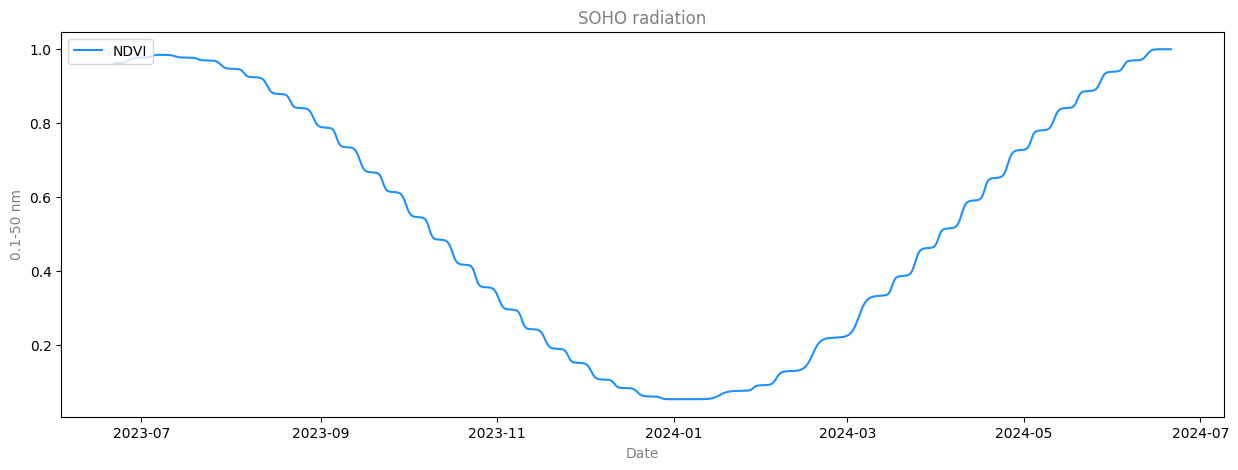

In [27]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(trimmed_data.index, trimmed_data["NDVI_normalized"], color="dodgerblue", label="NDVI")
plt.legend(loc='upper left')
plt.xlabel('Date', color='grey')
plt.ylabel('0.1-50 nm', color='grey')
plt.title('SOHO radiation', color='grey')
plt.legend(loc='upper left')
plt.savefig("../img/soho.png")
plt.show()

In [25]:
trimmed_data.to_csv("../data/NDVI_muir.csv")

In [26]:
trimmed_data.shape

(17532, 4)